Creating heatmaps from the positions recorded by my GPS watch

In [1]:
using DIVAnd
using PyPlot
using Test
using Dates
using PyCall
push!(LOAD_PATH, pwd())
using GPXheat
using NCDatasets

## Data from Argo
http://www.argodatamgt.org/Access-to-data/Argo-data-selection

In [13]:
"""
Generate a list of files (*.gpx) inside a given directory.
"""
function get_filelist(datadir::String)::Array
    filelist = []
    for (root, dirs, files) in walkdir(datadir)
        for file in files
            if endswith(file, ".nc")
                push!(filelist, joinpath(root, file))
            end
        end
    end
    @info("Found $(length(filelist)) files")
    return filelist
end;

In [93]:
datadir = "/media/ctroupin/My Passport/Argo/Trajectories/"
outputdir = "../netCDF/"
if isdir(datadir)
    @info("ok")
    datafilelist = get_filelist(datadir);
else
    @warn("Directory does not exist")
end

┌ Info: ok
└ @ Main In[93]:4
┌ Info: Found 8328 files
└ @ Main In[13]:13


8328-element Array{Any,1}:
 "/media/ctroupin/My Passport/Argo/Trajectories/13857_Rtraj.nc"  
 "/media/ctroupin/My Passport/Argo/Trajectories/13858_Rtraj.nc"  
 "/media/ctroupin/My Passport/Argo/Trajectories/13859_Rtraj.nc"  
 "/media/ctroupin/My Passport/Argo/Trajectories/15819_Rtraj.nc"  
 "/media/ctroupin/My Passport/Argo/Trajectories/15820_Rtraj.nc"  
 "/media/ctroupin/My Passport/Argo/Trajectories/15851_Rtraj.nc"  
 "/media/ctroupin/My Passport/Argo/Trajectories/15852_Rtraj.nc"  
 "/media/ctroupin/My Passport/Argo/Trajectories/15853_Rtraj.nc"  
 "/media/ctroupin/My Passport/Argo/Trajectories/15854_Rtraj.nc"  
 "/media/ctroupin/My Passport/Argo/Trajectories/15855_Rtraj.nc"  
 "/media/ctroupin/My Passport/Argo/Trajectories/1900022_Rtraj.nc"
 "/media/ctroupin/My Passport/Argo/Trajectories/1900033_Rtraj.nc"
 "/media/ctroupin/My Passport/Argo/Trajectories/1900034_Rtraj.nc"
 ⋮                                                               
 "/media/ctroupin/My Passport/Argo/Trajectories/5

In [89]:
function read_coords_argo(datafile::String)
    NCDatasets.Dataset(datafile) do ds
        lon = NCDatasets.varbyattrib(ds, standard_name="longitude")[1][:];
        lat = NCDatasets.varbyattrib(ds, standard_name="latitude")[1][:];
        time = ds["JULD"][:]
        
        goodcoords = .!ismissing.(lon) .& .!ismissing.(lat) .& .!ismissing.(time);;
       
        return lon[goodcoords]::Vector{Union{Missing, Float64}}, 
        lat[goodcoords]::Vector{Union{Missing, Float64}}, 
        time[goodcoords]::Vector{Union{Missing, DateTime}}
    end;
end

read_coords_argo (generic function with 2 methods)

In [90]:
function read_coords_argo(datafilelist::Array)
    nfiles = length(datafilelist)
    lon = Vector{Vector{Float64}}(undef, nfiles)
    lat = Vector{Vector{Float64}}(undef, nfiles) 
    time = Vector{Vector{Dates.DateTime}}(undef, nfiles)
    @info("Reading $(nfiles) files")
    
    for (id, datafile) in enumerate(datafilelist)
        #if isfile(datafile)
        lon[id], lat[id], time[id] = read_coords_argo(datafile)
    end
    return reduce(vcat, lon)::Vector{Float64}, reduce(vcat, lat)::Vector{Float64}, 
    reduce(vcat, time)::Vector{DateTime}
end

read_coords_argo (generic function with 2 methods)

In [94]:
@time lons, lats, ts = read_coords_argo(datafilelist);

┌ Info: Reading 8328 files
└ @ Main In[90]:6


286.201382 seconds (57.87 M allocations: 15.533 GiB, 0.59% gc time)


In [98]:
@time write_nc_traj("all.nc", lons, lats, ts);

 10.891323 seconds (159.86 M allocations: 3.347 GiB, 6.46% gc time)


In [96]:
"""
Write heatmap in a netCDF file
"""
function write_nc_traj(filename::String, lons, lats, times; valex=-999.9)
    Dataset(filename, "c") do ds

        # Dimensions
        ds.dim["time"] = length(times)

        # Declare variables
        nctime = defVar(ds,"time", Float64, ("time",))
        nctime.attrib["missing_value"] = Float64(valex)
        nctime.attrib["_FillValue"] = Float64(valex)
        #nctime.attrib["units"] = "degrees East"
        nctime.attrib["time"] = "time"
        
        nclon = defVar(ds,"lon", Float64, ("time",))
        nclon.attrib["missing_value"] = Float64(valex)
        nclon.attrib["_FillValue"] = Float64(valex)
        nclon.attrib["units"] = "degrees East"
        nclon.attrib["lon"] = "longitude"

        nclat = defVar(ds,"lat", Float64, ("time",))
        nclat.attrib["missing_value"] = Float64(valex)
        nclat.attrib["_FillValue"] = Float64(valex)
        nclat.attrib["units"] = "degrees North"
        nclat.attrib["lat"] = "latitude"

        # Global attributes
        ds.attrib["institution"] = "GHER - University of Liege"
        ds.attrib["title"] = "Argo float coordinates"
        ds.attrib["author"] = "C. Troupin, ctroupin@uliege"
        ds.attrib["institution_url"] = "http://modb.oce.ulg.ac.be/"
        ds.attrib["institution_logo_url"] = "http://gher-diva.phys.ulg.ac.be/Images/gher-logo.png"

        # Define variables
        nctime[:] = times
        nclon[:] = lons
        nclat[:] = lats;
    end
end;

### Select according to time period

In [100]:
yearnum = 2020
monthnum = 3
timeselector = (Dates.month.(ts) .== monthnum) .& (Dates.year.(ts) .== yearnum);
lons, lats, times = lons[timeselector], lats[timeselector], ts[timeselector];
@show(length(times));

length(times) = 22531


### Domain and resolution

In [101]:
longrid = -180.0:0.5:180.
latgrid = -80.:0.5:80.

-80.0:0.5:80.0

### Create mask and compute metrics

In [102]:
bathfile = "gebco_30sec_16.nc"

"gebco_30sec_16.nc"

In [103]:
_, (pm,pn), (xi,yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid);
_, _, mask = DIVAnd.load_mask(bathfile, true, longrid, latgrid, [0.0]);

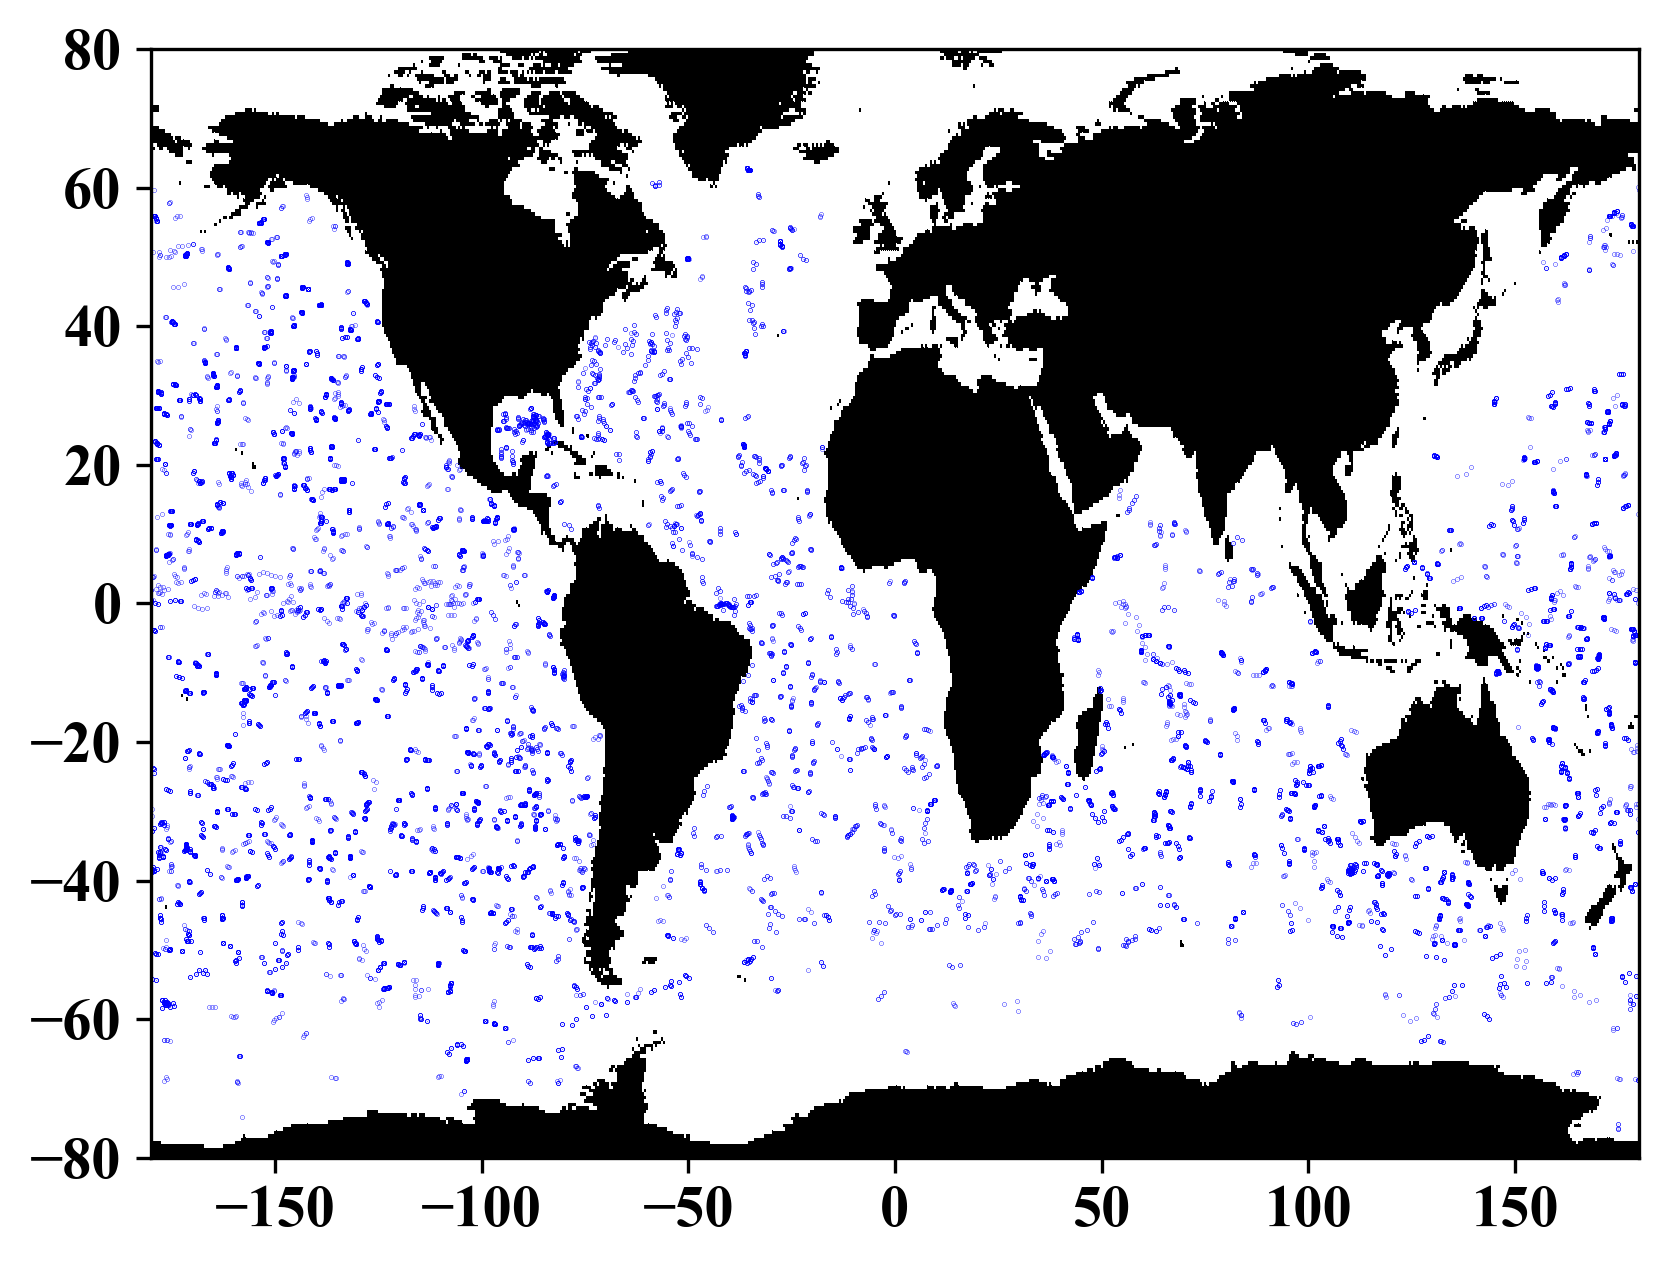

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3d41629ed0>

In [104]:
pcolormesh(xi, yi, mask[:,:,1], cmap=PyPlot.cm.binary_r)
plot(lons, lats, "bo", markersize=0.1)

### Computation
#### 1. Uniform inflation

In [105]:
inflation = ones(length(lons))
@time dens1, LHM1, LCV1, LSCV1 = DIVAnd_heatmap(mask[:,:,1], (pm,pn), (xi,yi),
    (lons,lats), inflation, 2.; Ladaptiveiterations=0);

┌ Warning: Data array size (22531,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/IHslM/src/DIVAnd_heatmap.jl:48


178.721224 seconds (50.01 M allocations: 55.133 GiB, 1.32% gc time)


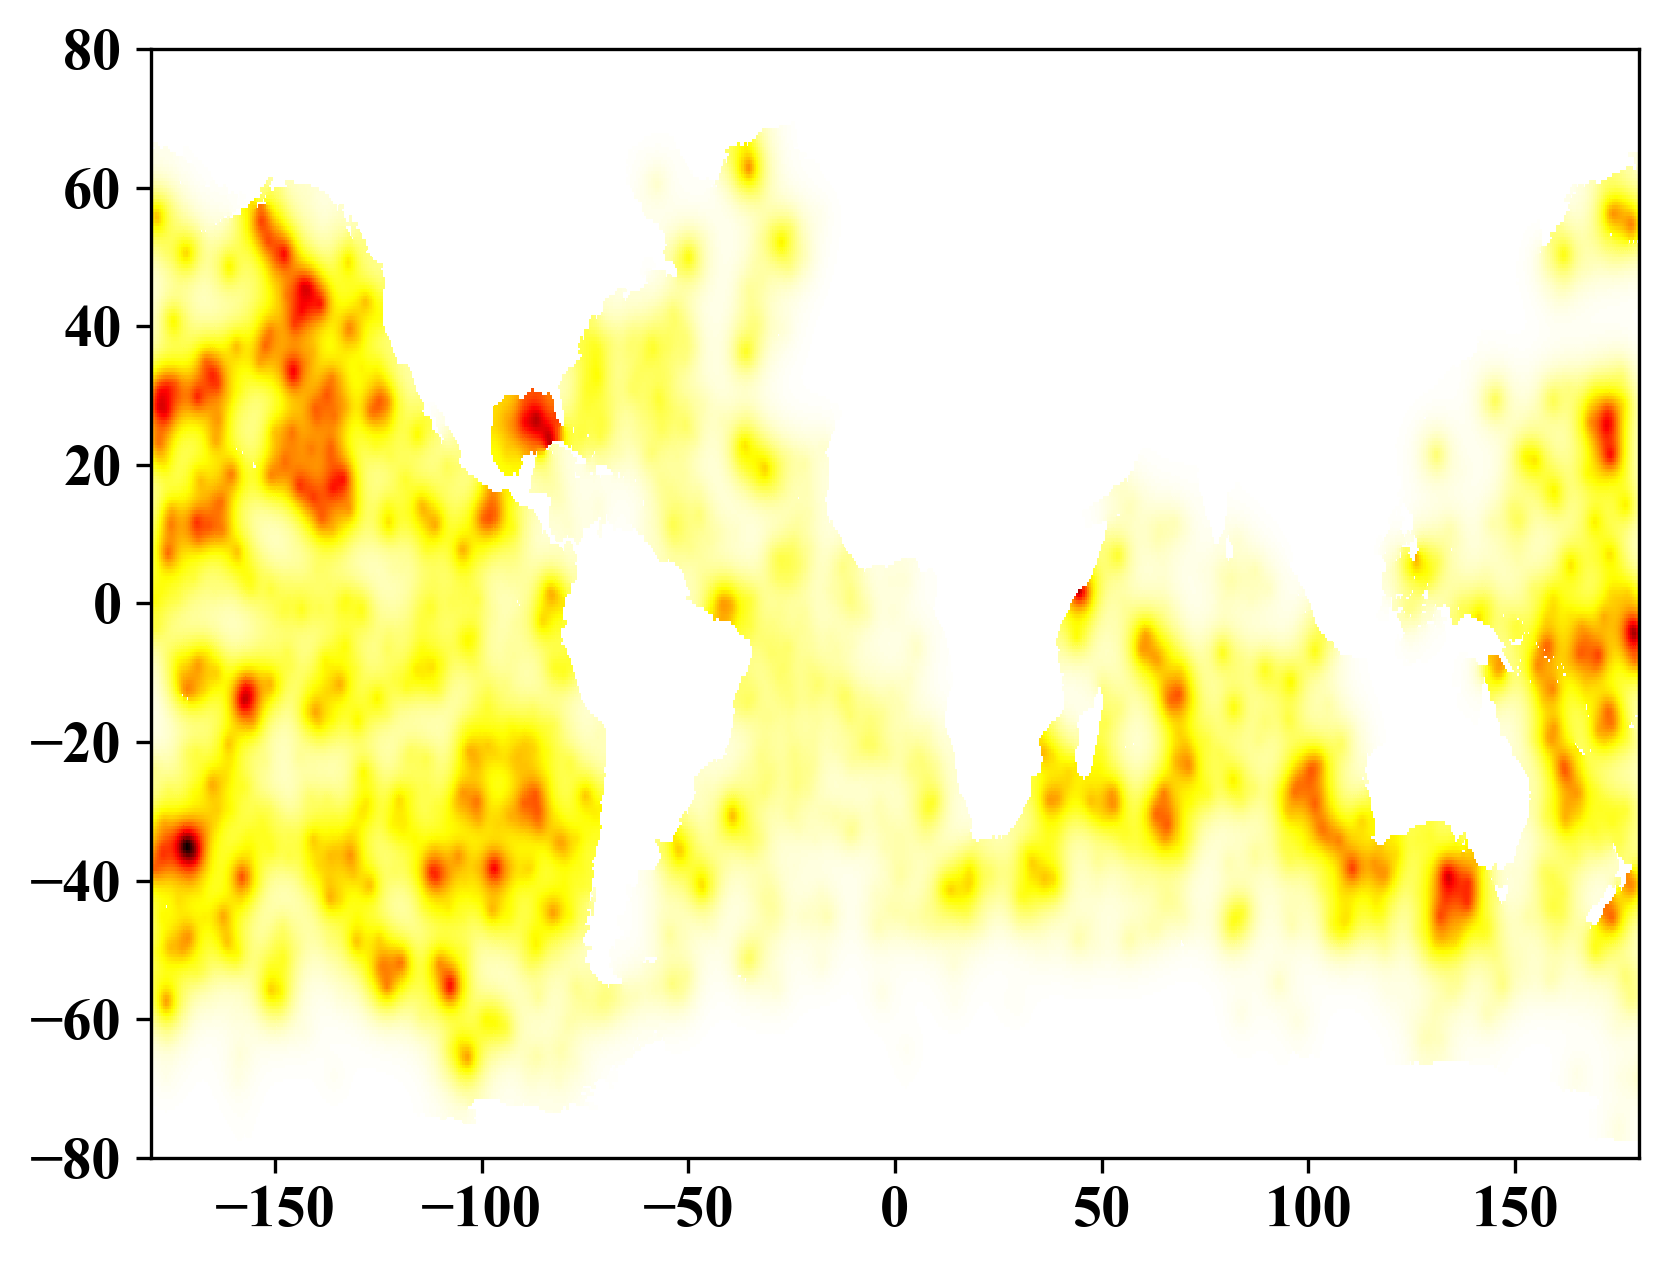

PyObject <matplotlib.collections.QuadMesh object at 0x7f3d4bd25d90>

In [106]:
pcolormesh(xi, yi, dens1, cmap=PyPlot.cm.hot_r)

In [47]:
GPXheat.write_nc_heat(joinpath(outputdir, "Argo$(yearnum)$(monthnum).nc"), longrid, latgrid, dens1; 
    valex=-999.9)

-80.0:0.5:80.0